In [88]:
# Change here using YOUR own first and last names
fn1 = "Jiale"
ln1 = "KANG"
filename = "_".join(map(lambda s: s.strip().lower(),
["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"

In [89]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error as sklearn_mse
from sklearn.metrics import r2_score as sklearn_r2
import numpy as np

from scipy import stats

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from scipy.stats import norm
import matplotlib.pyplot as plt

# 1)

For the first question, we load a standard dataset from sklearn.datasets named fetch_california_housing. This dataset has only p = 8 variables.

(a) Estimate the coefficients with the expression of the normal equaitons seen in class. Code two functions to compute the MSE and the R2 coefficient and compare them with the version of sklearn for the train and the test sets.

(b) Finally, give the confidence intervals at level 99% for all the coefficients coding the expression for the CI seen in session 3.

In [90]:
data_set = fetch_california_housing()
X = data_set.data
y = data_set.target

X = np.c_[np.ones(X.shape[0]), X]

# theta = (X^T X)^(-1) X^T y
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def compute_MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def compute_R2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

y_pred = X.dot(theta)

my_mse = compute_MSE(y, y_pred)
my_r2 = compute_R2(y, y_pred)

sklearn_mse = sklearn_mse(y, y_pred)
sklearn_r2 = sklearn_r2(y, y_pred)

print("my MSE:", my_mse, "Sklearn MSE:", sklearn_mse)
print("my R2 :", my_r2, "Sklearn R2 :", sklearn_r2)

my MSE: 0.5243209861846072 Sklearn MSE: 0.5243209861846072
my R2 : 0.606232685199805 Sklearn R2 : 0.606232685199805


In [91]:
# Compute the residuals and their variance
residuals = y - y_pred
sigma_squared = np.mean(residuals ** 2)

# Compute the standard errors
XtX_inv = np.linalg.inv(X.T.dot(X))
standard_errors = np.sqrt(np.diag(sigma_squared * XtX_inv))

z = stats.norm.ppf(0.995)
confidence_intervals = [(theta[i] - z * standard_errors[i], theta[i] + z * standard_errors[i]) for i in range(len(theta))]

for i, ci in enumerate(confidence_intervals):
    print(f"Coefficient {i}: 99% CI = {ci}")


Coefficient 0: 99% CI = (-38.63874945279466, -35.24509096297883)
Coefficient 1: 99% CI = (0.42588540249205775, 0.4475011837732037)
Coefficient 2: 99% CI = (0.008286488997031634, 0.010585067069203811)
Coefficient 3: 99% CI = (-0.12247846826776403, -0.0921656145108715)
Coefficient 4: 99% CI = (0.572610684710455, 0.7175207023205837)
Coefficient 5: 99% CI = (-1.6206846473170617e-05, 8.254067629997683e-06)
Coefficient 6: 99% CI = (-0.005041766360823468, -0.002531318949078104)
Coefficient 7: 99% CI = (-0.4398482343307896, -0.40278052073882914)
Coefficient 8: 99% CI = (-0.45391296291327266, -0.41511454645276)


# 2)

For the rest of the TP, we use the dataset in eCampus data. Load and preprocess the data:

(a) Separate the data in train and test sets: save one fourth of the data as testing (train_test_split from sklearn.model_selection with the random seed set to 0 and
standardize both the training and testing sets using the fit_transform and transform functions in sklearn.preprocessing.StandardScaler.

(b) Fit a regular OLS.

In [92]:
data = pd.read_csv("data.csv", sep=",", header=None)

# Set the random seed to 0
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(data.drop(210, axis=1), data[210], test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # do not fit test set
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
# y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel() # do not fit test set

# display(np.mean(y_train_scaled, axis=0))

# Fit a regular OLS
reg = LinearRegression(fit_intercept=False).fit(X_train_scaled, y_train_scaled)
# print(f'R^2 = {reg.score(X_test_scaled, y_test_scaled)}')

# 3)

Program the method of forward variable selection based on hypothesis tests for regression coefficients.
This method starts from an empty set of variables S and at each iteration selects one variable relevant for predicting y and includes it in the set S. It runs until a halting condition is met. The coding process is as follows:

(a) Develop a function that, given a dataset X P Rnp and y, fits p linear regression models, each using only feature Xj to predict y. For each model, conduct a test of no effect, as discussed in session 3, and compute the p-value of the test. This function should return the coefficient with the smallest p-value. Explain the significance of the p-value in this context.

(b) Apply the function iteratively. At each iteration, select the feature Xf with the smallest
p-value and:
i. Include it in the set S.
ii. Remove it from X.
iii. Subtract from y the residuals of the model fit with feature Xf . Elaborate on the reason
for subtracting the residuals.

(c) Add a halting condition to the algorithm: Stop adding features to the set S when the p-value
exceeds 0.05. Plot the p-values for every coefficient for the first 5 iterations (all in the same
plot).

In [93]:
def choose_single_variable(X, y, plot_flag, plot_label):
    '''
    Choose the best single variable to predict y from X.
    X: numpy array of shape (n, p)
    y: numpy array of shape (n,)
    Return: (min_feature_idx, min_p_value, x_min, theta)
    '''
    n, p = X.shape  
    p_values = []
    y_temp = y.copy().ravel()

    # Iterate through all unselected features to find the one with smallest p-value
    for k in range(p):
        X_temp = X[:, k]  # Select column with index k
        # centerilize X and y
        Xc = X_temp - np.mean(X_temp)
        yc = y_temp - np.mean(y_temp)

        # fit a regular OLS
        reg = LinearRegression().fit(Xc.reshape(-1, 1), yc)
        theta = reg.coef_
        y_pred = reg.predict(Xc.reshape(-1, 1))
        sigma = np.sqrt(np.var(yc - y_pred))
        T = np.sqrt(n) * abs(theta) / sigma
        p_value = 2 * (1 - norm.cdf(T))
        p_values.append([k, p_value, Xc, theta])

    if plot_flag:
        k_values = [entry[0] for entry in p_values]
        p_values_list = [entry[1] for entry in p_values]
        plt.plot(k_values, p_values_list, label=plot_label)
        plt.legend()

    return min(p_values, key=lambda x: x[1])

feature index : 34, p_value : [0.]
feature index : 57, p_value : [0.]
feature index : 77, p_value : [2.40162046e-09]
feature index : 120, p_value : [1.34464899e-06]
feature index : 131, p_value : [0.00234623]
feature index : 162, p_value : [0.00036706]
feature index : 30, p_value : [0.00382328]
feature index : 74, p_value : [0.01119774]
feature index : 160, p_value : [0.0064599]
feature index : 165, p_value : [0.01315699]
feature index : 123, p_value : [0.02635326]
feature index : 172, p_value : [0.04293478]
feature index : 13, p_value : [0.0437509]


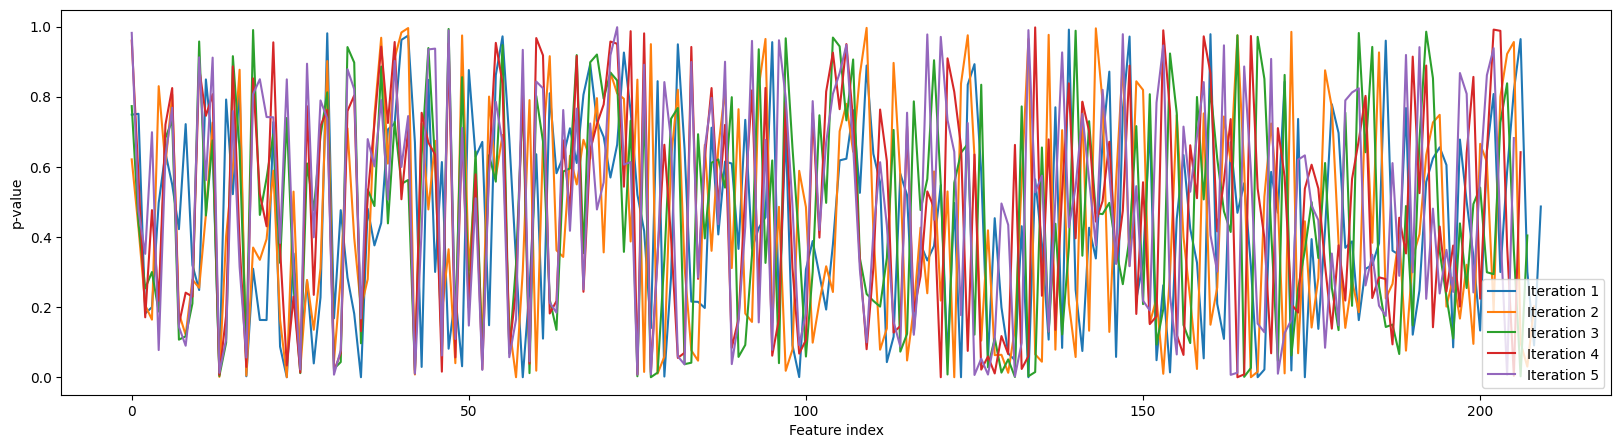

In [94]:
def forward_variable_selection(X, y, p_value_threshold=0.05, show_flag=False, plot_iter=5):
    '''
        X : numpy array of shape (n, p)
        y : numpy array of shape (n, 1)
        verbose : boolean
        p_value_threshold : float
    '''

    n, p = X.shape  
    remaining_features = list(range(0, p))
    chosed_features = []
    X_temp = X.copy()
    y_temp = y.copy().ravel()

    for i in range(p):

        plot_flag = False
        if (plot_iter != 0) and (i < plot_iter):
            plot_flag = True
            plot_label = f'Iteration {i + 1}'

        min_feature_idx, min_p_value, x_min, theta = choose_single_variable(X_temp, y_temp, plot_flag, plot_label)

        if min_p_value > p_value_threshold:
            break

        if show_flag:
            print(f'feature index : {min_feature_idx}, p_value : {min_p_value}')
            
        y_temp = y_temp - theta * x_min 

        chosed_features.append([min_feature_idx, min_p_value])
        X_temp = np.delete(X_temp, min_feature_idx, axis=1)
        remaining_features.remove(min_feature_idx)

    return chosed_features

plt.figure(figsize=(20, 5))
forward_variable_selection(X_train_scaled, y_train_scaled, p_value_threshold=0.05, show_flag=True, plot_iter=5)
plt.xlabel('Feature index')
plt.ylabel('p-value')
plt.show()

# 4)

Run ridge regression using scikit-learn on the training set. Run the code for 30 different values of the penalty parameter, which should be on a logarithmic scale between 101 and 106. Display two subplots at the end:

(a) The first subplot should show the evolution of the coefficients for each different value of the penalty parameter.

(b) The second subplot should display the evolution of the R-squared coefficient at each of the 30 iterations.